[华安创业板50ETF](https://finance.sina.com.cn/fund/quotes/159949/bc.shtml)

[深圳证券交易所](http://www.szse.cn/market/product/list/etfList/index.html)

https://finance.sina.com.cn/stock/stockzmt/2020-03-18/doc-iimxyqwa1302257.shtml

https://blog.csdn.net/qq_41648495/article/details/114380780

根据[循环回测](#%E5%BE%AA%E7%8E%AF%E5%9B%9E%E6%B5%8B)发现一个有趣的现象，虽然正向收益的年份，收益率均不如基准，但是在负向收益的年份，却可以产生较少的负向收益，甚至产生正向收益（这应该是因为我们区分了上涨市和下跌市的不同操作而做到的），并且所有年份中的策略最大回撤均低于基准最大回撤。

所以这中策略应该还算是一个可以备选的策略。

每年浮动盈亏比较：

---

（以`399300`作为基准比较）

|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2018-01-01~2018-12-31 |                                        0.744251 |                            0.890506 |                                  0.744251 |                      0.890506 |         27 |         31 |                  0   |                  0   |      -0.316742 |     -0.141443  |
| 2019-01-01~2019-12-31 |                                        2.10205  |                            2.0958   |                                  1.3578   |                      1.20529  |         17 |         21 |                  0   |                  0   |      -0.131147 |     -0.0851096 |
| 2020-01-01~2020-12-31 |                                        3.36651  |                            4.18638  |                                  1.26446  |                      2.09058  |         55 |         22 |              20307.2 |              20824.9 |      -0.162244 |     -0.127241  |

---

（以`159949`作为基准比较）

|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2018-01-01~2018-12-31 |                                        0.646884 |                            0.890506 |                                  0.646884 |                      0.890506 |         27 |         31 |                  0   |                  0   |      -0.416072 |     -0.141443  |
| 2019-01-01~2019-12-31 |                                        2.15947  |                            2.0958   |                                  1.51259  |                      1.20529  |         17 |         21 |                  0   |                  0   |      -0.216143 |     -0.0851096 |
| 2020-01-01~2020-12-31 |                                        4.03184  |                            4.18638  |                                  1.87237  |                      2.09058  |         55 |         22 |              20307.2 |              20824.9 |      -0.206906 |     -0.127241  |

In [1]:
# import logging
# logging.basicConfig(level=logging.DEBUG) 

import numpy as np
import talib
import pandas as pd
from tqdm import tqdm_notebook
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import matplotlib.pyplot as plt

you are using non-interactive mdoel quantaxis


### 原始数据

In [2]:
CODE='159949'
START='2016-06-30'
END='2019-12-31'
INIT_CASH=10000
DEFAULT_MA=20

In [3]:
def get_data(code,start,end,ma=DEFAULT_MA):
    ori_data = QA.QA_fetch_index_day_adv(code,start=start,end=end).data.reset_index(level=1, drop=True)
    data_qfq = ori_data
    # 收盘价变化率
    data_qfq['pct'] = data_qfq['close'].pct_change()
    data_qfq['date'] = data_qfq.index.get_level_values(0)
    data_qfq['date'] = pd.to_datetime(data_qfq['date'])
    # 星期一为0，星期天为6
    data_qfq['weekday'] = data_qfq['date'].dt.weekday
    data_qfq['nextday']=data_qfq['weekday'].shift(-1)
    # 简单移动均线
    data_qfq["MA"] = QA.QA_indicator_MA(data_qfq, ma)
    data_qfq['avg_price']=(data_qfq['close']+data_qfq['open']+data_qfq['high']+data_qfq['low'])/4
    data_qfq['avg_pct'] = data_qfq['avg_price'].pct_change()
    data_qfq['up']=False
    data_qfq['down']=False
    data_qfq.loc[data_qfq['close']>data_qfq["MA"],'up']=True
    data_qfq.loc[data_qfq['close']<data_qfq["MA"],'down']=True
    data_qfq['prev_up']=data_qfq['up'].shift()
    data_qfq['prev_down']=data_qfq['down'].shift()

    data_qfq.dropna(inplace=True)
    return data_qfq

In [4]:
data_qfq=get_data(CODE,START,END)
data_qfq.head(1)

,open,close,high,low,vol,amount,date_stamp,volume,pct,date,weekday,nextday,MA,avg_price,avg_pct,up,down,prev_up,prev_down
date,,,,,,,,,,,,,,,,,,,
2016-08-18,0.954,0.959,0.964,0.954,64955.0,6225123.0,1.4714e+09,64955.0,-0.001,2016-08-18,3,4.0,0.9403,0.9577,-0.0026,True,False,False,False


<AxesSubplot:xlabel='date'>

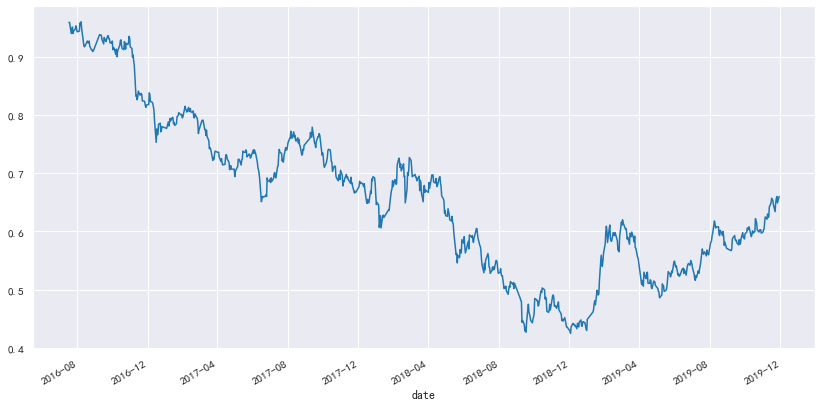

In [5]:
get_data(CODE,START,END).close.plot()

In [6]:
def get_desc(data,**kwargs):
    data['change']=(data['close']-data['open'])/data['close']
    pct=data.groupby('weekday')['pct'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '收盘价涨跌幅均值',
        'median': '收盘价涨跌幅中位数'
    })
    pct1=data.groupby('weekday')['avg_pct'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '日均值涨跌幅均值',
        'median': '日均值涨跌幅中位数'
    })
    pct2=data.groupby('weekday')['change'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '日收盘相对开盘涨跌幅均值',
        'median': '日收盘相对开盘涨跌幅中位数'
    })
    # 胜率
    temp1 = data.groupby('weekday')['pct'].size()
    temp2 = data[data['pct'] > 0].groupby(
    'weekday')['pct'].size()
    win_rate=(temp2 / temp1).to_frame('收盘价涨跌幅胜率').sort_values(
    '收盘价涨跌幅胜率', ascending=False)
    
    df=pct.join(win_rate).join(pct1).join(pct2).sort_index()
    df.set_index(pd.Index(['周一','周二','周三','周四','周五']),inplace=True)
    return df

def show_desc(data,info_only=True,**kwargs):
    df=get_desc(data,**kwargs)
    if not info_only:
        f = plt.figure(figsize=(15,3))
        ax1 = f.add_subplot(131)
        ax2 = f.add_subplot(132)
        ax3 = f.add_subplot(133)

        ax1.plot(df.index, df[['收盘价涨跌幅均值','收盘价涨跌幅中位数']])
        ax1.legend(['均值','中位数'])
        ax1.set_title("收盘价涨跌幅")

        ax2.plot(df.index, df[['日均值涨跌幅均值','日均值涨跌幅中位数']])
        ax2.legend(['均值','中位数'])
        ax2.set_title("日均值涨跌幅")

        ax3.plot(df.index, df[['日收盘相对开盘涨跌幅均值','日收盘相对开盘涨跌幅中位数']])
        ax3.legend(['均值','中位数'])
        ax3.set_title("日均值涨跌幅")
        
        plot_title=kwargs.pop('plot_title',"")
        f.suptitle(plot_title)
    
    return df.T.style.highlight_max(color='red', axis=1).highlight_min(
        color='green', axis=1).format("{:.2%}")

,周一,周二,周三,周四,周五
收盘价涨跌幅均值,0.12%,0.10%,-0.20%,-0.17%,0.01%
收盘价涨跌幅中位数,-0.11%,0.14%,-0.27%,-0.16%,-0.17%
收盘价涨跌幅胜率,45.62%,51.83%,36.53%,41.57%,44.17%
日均值涨跌幅均值,0.05%,0.03%,-0.03%,-0.16%,-0.09%
日均值涨跌幅中位数,-0.13%,0.20%,-0.06%,-0.17%,-0.14%
日收盘相对开盘涨跌幅均值,0.01%,0.14%,-0.18%,-0.15%,-0.01%
日收盘相对开盘涨跌幅中位数,0.00%,0.21%,-0.33%,-0.16%,-0.14%


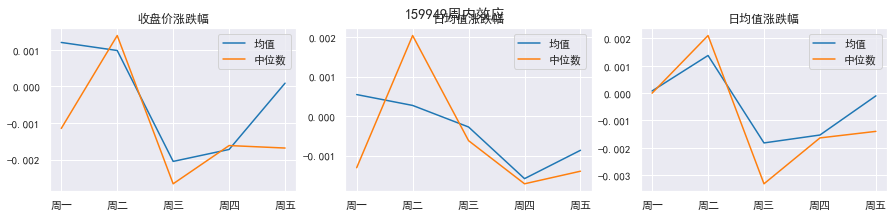

In [7]:
show_desc(data_qfq,False,plot_title='{}周内效应'.format(CODE))

In [8]:
def simple_test(data,plot=True,**kwargs):
    """
    **未考虑T+1交易的情况**
    Args:
        trade_func: 交易方法。用来在data中标记buy和sell。默认为None。
        plot_title: 绘图时的标题
    """
    dt=data.copy()
    dt['buy']=0
    dt['sell']=0
    trade_func=kwargs.pop('trade_func',None)
    trade_func_params=kwargs.pop('trade_func_params',{})
    if trade_func:
        trade_func(dt,**trade_func_params)
    dt['每日均价变更']=dt['avg_price'].pct_change()
    dt['每日开盘/收盘变更']=dt['close']/dt['open']-1
    dt['每日收盘价变更']=dt['close'].pct_change()
    # 持仓标记
    dt['hold']=dt['buy'].replace(0, np.NaN).fillna(method='ffill')
    dt.loc[(dt['hold']==1)&(dt['sell']==1),'hold']=np.NaN
    dt['hold'].fillna(0,inplace=True)
    #考虑A股T+1特性，去除前后hold均为0但当天hold为1的数据
    dt['hold_real']=dt['hold']
    dt.loc[(dt['hold_real']==1)&(dt['hold_real'].shift()==0)&(dt['hold_real'].shift(-1)==0),'hold_real']=0
    dt['策略-每日均价累加']=(dt['每日均价变更']*dt['hold']).cumsum()
    dt['策略T+1-每日均价累加']=(dt['每日均价变更']*dt['hold_real']).cumsum()
    dt['基准-每日均价累加']=(dt['每日均价变更']).cumsum()
    dt['策略-每日收盘价累加']=(dt['每日收盘价变更']*dt['hold']).cumsum()
    dt['策略T+1-每日收盘价累加']=(dt['每日收盘价变更']*dt['hold_real']).cumsum()
    dt['基准-每日收盘价累加']=(dt['每日收盘价变更']).cumsum()
    if plot:
        f = plt.figure(figsize=(15,3))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(dt.index,dt['策略-每日均价累加'],label='策略')
        ax1.plot(dt.index,dt['策略T+1-每日均价累加'],label='策略T+1')
        ax1.plot(dt.index,dt['基准-每日均价累加'],label='基准')
        ax1.legend()
        ax1.set_title("每日均价变更")
        ax2.plot(dt.index,dt['策略-每日收盘价累加'],label='策略')
        ax2.plot(dt.index,dt['策略T+1-每日收盘价累加'],label='策略T+1')
        ax2.plot(dt.index,dt['基准-每日收盘价累加'],label='基准')
        ax2.legend()
        ax2.set_title("每日收盘价变更")
    return dt

以`收盘价涨跌幅胜率`来看，应该只保留周二一天

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周二(1)|开盘价(open)|
|周二(1)|周二(1)|开盘价(open)|
|周三(2)|周二(1)|收盘价(close)|
|周四(3)|周二(1)|收盘价(close)|
|周五(4)|周二(1)|收盘价(close)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周一(0)、周三(2)、周四(3)、周五(4)|收盘价(close)|
|周二(1)|周一(0)、周三(2)、周四(3)、周五(4)|收盘价(close)|
|周三(2)|周一(0)、周三(2)、周四(3)、周五(4)|开盘价(open)|
|周四(3)|周一(0)、周三(2)、周四(3)、周五(4)|开盘价(open)|
|周五(4)|周一(0)、周三(2)、周四(3)、周五(4)|开盘价(open)|

In [9]:
def simple_trade_func(data,**kwargs):
    data.loc[(data['nextday'].isin([1])),'buy']=1
    data.loc[~(data['weekday'].isin([1])),'sell']=1
    data.iloc[-1,data.columns.get_loc('buy')]=np.NaN
    data.iloc[-1,data.columns.get_loc('sell')]=np.NaN
    return data

# simple_data=simple_test(get_data(CODE,START,END),trade_func=simple_trade_func)

回归测试

实际操作过程中，**胜率超过50%，收益率高于基准（虽然都是负收益）**

In [10]:
def simple_buy_price_func(index, row, data):
    tom = data.iloc[data.index.get_loc(index)+1]
    if row['weekday'] in (0,1):
        return row['open']
    else:
        return row['close']

def simple_sell_price_func(index, row, data):
    if row['weekday'] in (0,1):
        return row['close']
    else:
        return row['open']

from gquant.backtest import backtest
x = get_data(CODE, START, END)
y = get_data('399300', START, END)#以399300作为基准比较
simple_trade_func(x)
m = backtest(x, benchmark_pd=y, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

820it [00:00, 827.79it/s]


基准收益                           0.2849
策略收益                          -0.0539
基准年化收益                         0.0852
策略年化收益                        -0.0161
基准最大回撤                        -0.3229
策略最大回撤                        -0.2885
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.2482
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    0.9335
dtype: float64

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

初始资金                     10000.0000
剩余现金                      9335.4949
交易次数                       163.0000
未结束交易次数                      0.0000
未结束交易购买金额                    0.0000
未结束交易当前价值                    0.0000
盈利次数                        92.0000
亏损次数                        68.0000
盈利次数占比                       0.5644
盈利(含交易费)次数                  92.0000
亏损(含交易费)次数                  71.0000
盈利(含交易费)次数占比                 0.5644
盈利交易平均获利                   137.1174
亏损交易平均亏损                  -182.8603
盈利(含交易费)交易平均获利             137.1174
亏损(含交易费)交易平均亏损            -175.1338
盈亏总额                       180.3000
手续费总额                      844.8051
手续费均值                        2.5914
最大盈利%                        0.0797
最大亏损%                       -0.1086
最大(含交易费)盈利%                  0.0791
最大(含交易费)亏损%                 -0.1091
基准浮动盈亏(基准最后收盘/基准最先开盘)        1.2482
结算价值(未结束交易当前价值+剩余现金)      9335.4949
浮动盈亏(结算价值/初始资金)              0.9335
dtype: float64


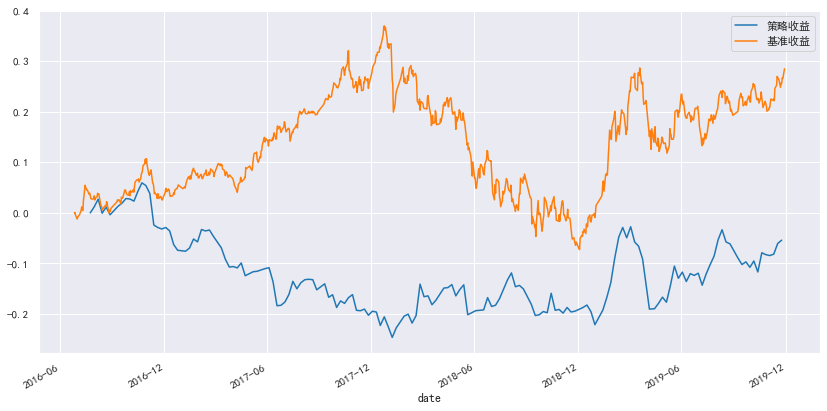

In [12]:
m.plot_cash()

下面考虑估计在上涨市（前日收盘价高于20日均线）、下跌市（前日收盘价低于20日均线）的市场中是否存在可以被利用的周内效应。

# 上涨市

In [13]:
x = get_data(CODE, START, END)
show_desc(x[x['prev_up']==True],info_only=True)

,周一,周二,周三,周四,周五
收盘价涨跌幅均值,0.55%,0.06%,-0.37%,-0.11%,-0.12%
收盘价涨跌幅中位数,0.40%,0.00%,-0.42%,0.00%,-0.29%
收盘价涨跌幅胜率,51.39%,49.28%,32.05%,41.33%,38.03%
日均值涨跌幅均值,0.48%,0.40%,-0.00%,-0.04%,0.05%
日均值涨跌幅中位数,0.17%,0.43%,-0.02%,-0.16%,-0.06%
日收盘相对开盘涨跌幅均值,0.39%,0.13%,-0.22%,-0.07%,-0.14%
日收盘相对开盘涨跌幅中位数,0.37%,0.18%,-0.27%,-0.14%,-0.27%


以`收盘价涨跌幅胜率`来看，应该只在周一持有股票

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周一(0)|开盘价(open)|
|周二(1)|周一(0)|开盘价(open)|
|周三(2)|周一(0)|收盘价(close)|
|周四(3)|周一(0)|收盘价(close)|
|周五(4)|周一(0)|收盘价(close)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周二(1)、周三(2)、周四(3)、周五(4)|收盘价(close)|
|周二(1)|周二(1)、周三(2)、周四(3)、周五(4)|收盘价(close)|
|周三(2)|周二(1)、周三(2)、周四(3)、周五(4)|开盘价(open)|
|周四(3)|周二(1)、周三(2)、周四(3)、周五(4)|开盘价(open)|
|周五(4)|周二(1)、周三(2)、周四(3)、周五(4)|开盘价(open)|

In [14]:
def _rasing_trade_fun_buy(data,**kwargs):
    data.loc[(data['prev_up']==True)&(data['nextday'].isin([0])),'buy']=1
    return data

def _rasing_trade_fun_sell(data,**kwargs):
    data.loc[(data['prev_up']==True)&(~data['nextday'].isin([0])),'sell']=1
    return data

def rasing_trade_func_fix(data,**kwargs):
    data=_rasing_trade_fun_buy(data,**kwargs)
    data=_rasing_trade_fun_sell(data,**kwargs)
    data.loc[data.shift()['up']!=True,'sell']=1
    return data

def rasing_buy_price_func(index, row, data):
    if row['weekday'] in (0,1):
        return row['open']
    else:
        return row['close']

def rasing_sell_price_func(index, row, data):
    if row['weekday'] in (0,1):
        return row['close']
    else:
        return row['open']

x = get_data(CODE, START, END)
y = get_data('399300', START, END)
rasing_trade_func_fix(x)
m = backtest(x, benchmark_pd=y[y['prev_up']==True], buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=rasing_buy_price_func, sell_price_func=rasing_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

820it [00:00, 2072.25it/s]


基准收益                           0.2581
策略收益                           0.2747
基准年化收益                         0.1364
策略年化收益                         0.1452
基准最大回撤                        -0.3005
策略最大回撤                        -0.0938
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.2626
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    1.2513
dtype: float64

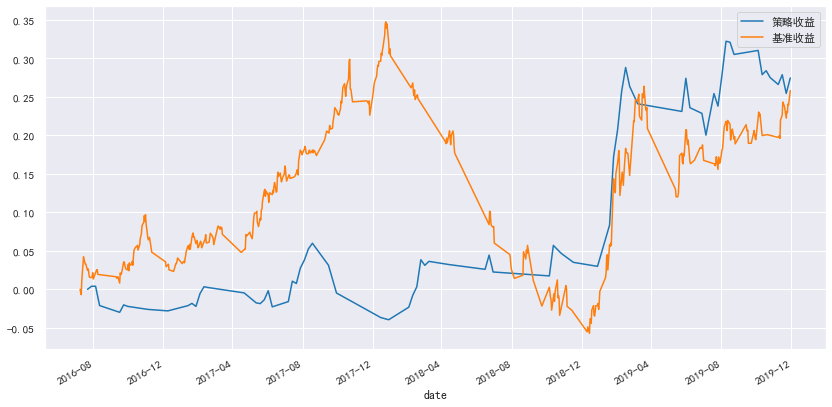

In [15]:
m.plot_cash()

# 下跌市

In [16]:
x = get_data(CODE, START, END)
show_desc(x[x['prev_down']==True],info_only=True)

,周一,周二,周三,周四,周五
收盘价涨跌幅均值,-0.23%,0.12%,-0.06%,-0.23%,0.11%
收盘价涨跌幅中位数,-0.19%,0.16%,-0.19%,-0.18%,0.00%
收盘价涨跌幅胜率,40.91%,53.68%,40.45%,42.22%,48.91%
日均值涨跌幅均值,-0.29%,-0.25%,-0.05%,-0.26%,-0.19%
日均值涨跌幅中位数,-0.47%,0.00%,-0.11%,-0.23%,-0.15%
日收盘相对开盘涨跌幅均值,-0.31%,0.14%,-0.15%,-0.23%,0.09%
日收盘相对开盘涨跌幅中位数,-0.22%,0.27%,-0.35%,-0.23%,0.00%


以`收盘价涨跌幅胜率`来看，应该只在周二持有股票。

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周二(1)|收盘价(close)|
|周二(1)|周二(1)|开盘价(open)|
|周三(2)|周二(1)|收盘价(close)|
|周四(3)|周二(1)|收盘价(close)|
|周五(4)|周二(1)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周一(0)、周三(2)、周四(3)、周五(4)|开盘价(open)|
|周二(1)|周一(0)、周三(2)、周四(3)、周五(4)|收盘价(close)|
|周三(2)|周一(0)、周三(2)、周四(3)、周五(4)|开盘价(open)|
|周四(3)|周一(0)、周三(2)、周四(3)、周五(4)|开盘价(open)|
|周五(4)|周一(0)、周三(2)、周四(3)、周五(4)|收盘价(close)|

In [17]:
def _falling_trade_func_buy(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([1])),'buy']=1
    return data

def _falling_trade_func_sell(data,**kwargs):
    data.loc[(data['prev_down']==True)&(~data['nextday'].isin([1])),'sell']=1
    return data

def falling_trade_func(data,**kwargs):
    data=_falling_trade_func_buy(data,**kwargs)
    data=_falling_trade_func_sell(data,**kwargs)
    data.loc[data.shift()['down']!=True,'sell']=1
    return data

def falling_buy_price_func(index, row, data):
    if row['weekday'] in (0,2,3):
        return row['close']
    else:
        return row['open']

def falling_sell_price_func(index, row, data):
    if row['weekday'] in (0,2,3):
        return row['open']
    else:
        return row['close']

x = get_data(CODE, START, END)
y = get_data('399300', START, END)
falling_trade_func(x)
m = backtest(x, benchmark_pd=y[y['prev_down']==True], buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=falling_buy_price_func, sell_price_func=falling_sell_price_func)
m.stats()

820it [00:00, 1750.47it/s]


基准收益                           0.2254
策略收益                           0.0906
基准年化收益                         0.1556
策略年化收益                         0.0625
基准最大回撤                        -0.3041
策略最大回撤                        -0.0909
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.2178
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    1.1142
dtype: float64

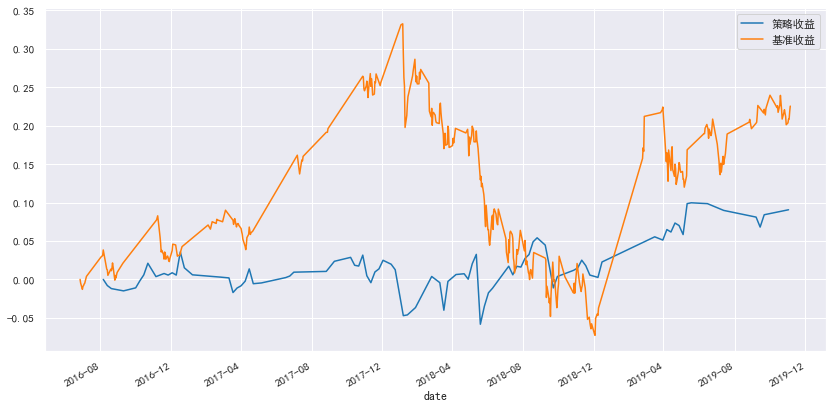

In [18]:
m.plot_cash()

---

# 合并上涨市和下跌市的买卖规则及买卖手法

In [19]:
def combine_trade_func_fix(data,**kwargs):
    data=_rasing_trade_fun_buy(data,**kwargs)
    data=_falling_trade_func_buy(data,**kwargs)
    data=_rasing_trade_fun_sell(data,**kwargs)
    data=_falling_trade_func_sell(data,**kwargs)
    return data

def combine_buy_price_func(index, row, data):
    if row['prev_up']==True:
        return rasing_buy_price_func(index,row,data)
    if row['prev_down']==True:
        return falling_buy_price_func(index,row,data)

def combine_sell_price_func(index, row, data):
    if row['prev_up']==True:
        return rasing_sell_price_func(index,row,data)
    if row['prev_down']==True:
        return falling_sell_price_func(index,row,data)


x = get_data(CODE, START, END)
y = get_data('399300', START, END)
x=combine_trade_func_fix(x)
m = backtest(x, benchmark_pd=y, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=combine_buy_price_func, sell_price_func=combine_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

820it [00:00, 1165.67it/s]


基准收益                           0.2849
策略收益                           0.4222
基准年化收益                         0.0852
策略年化收益                         0.1263
基准最大回撤                        -0.3229
策略最大回撤                        -0.1565
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.2482
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    1.4038
dtype: float64

合并了上涨市和下跌市两种条件及购买卖出操作后，竟然**稍稍超过了基准**（只是稍稍超过的可能是持仓交易日太少。与[159915](ETF周内效应-创业板-159915.ipynb#与159915比较)相比交易次数只有零头而已）。

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

初始资金                     10000.0000
剩余现金                     14037.9934
交易次数                       156.0000
未结束交易次数                      0.0000
未结束交易购买金额                    0.0000
未结束交易当前价值                    0.0000
盈利次数                        85.0000
亏损次数                        63.0000
盈利次数占比                       0.5449
盈利(含交易费)次数                  85.0000
亏损(含交易费)次数                  71.0000
盈利(含交易费)次数占比                 0.5449
盈利交易平均获利                   179.1976
亏损交易平均亏损                  -161.3921
盈利(含交易费)交易平均获利             179.1976
亏损(含交易费)交易平均亏损            -143.2070
盈亏总额                      5064.1000
手续费总额                     1026.1066
手续费均值                        3.2888
最大盈利%                        0.0833
最大亏损%                       -0.0879
最大(含交易费)盈利%                  0.0827
最大(含交易费)亏损%                 -0.0885
基准浮动盈亏(基准最后收盘/基准最先开盘)        1.2482
结算价值(未结束交易当前价值+剩余现金)     14037.9934
浮动盈亏(结算价值/初始资金)              1.4038
dtype: float64


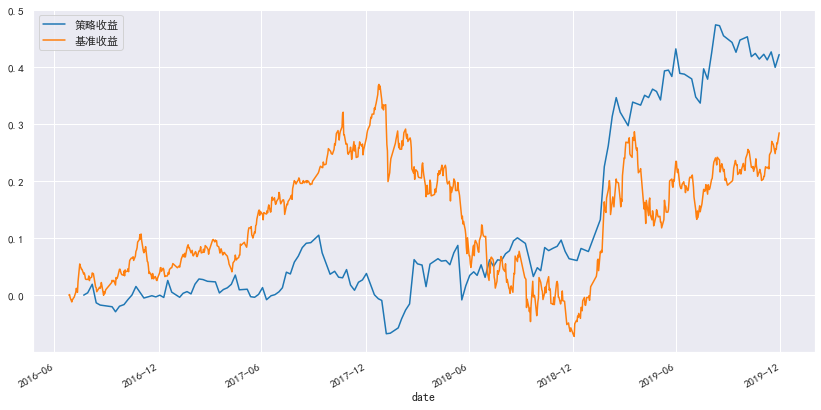

In [21]:
m.plot_cash()

---

# 盲测

In [22]:
x = get_data(CODE, '2001-12-01', '2021-12-31')

x = x['2020-01-01':'2020-12-31'].copy()
x=combine_trade_func_fix(x)
m = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=combine_buy_price_func, sell_price_func=combine_sell_price_func)
m.stats()

243it [00:00, 1075.27it/s]


基准收益                           0.8434
策略收益                           0.3951
基准年化收益                         0.8677
策略年化收益                         0.4065
基准最大回撤                        -0.2069
策略最大回撤                        -0.0820
基准浮动盈亏(基准最后收盘/基准最先开盘)          1.8724
策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金)    1.4101
dtype: float64

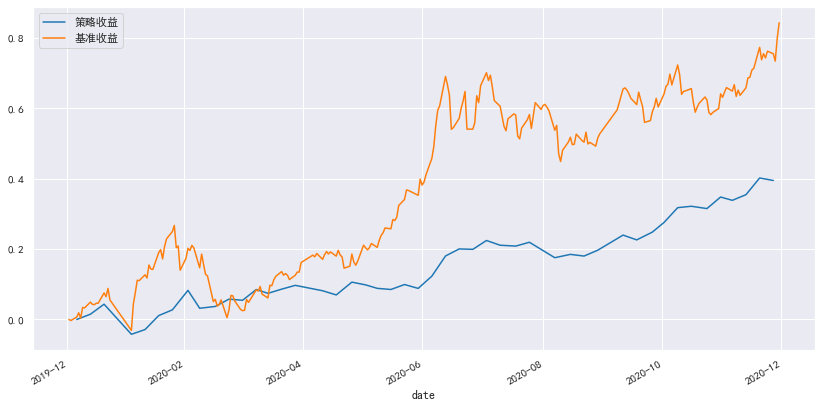

In [23]:
m.plot_cash()

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

初始资金                     10000.0000
剩余现金                         9.5628
交易次数                        49.0000
未结束交易次数                      1.0000
未结束交易购买金额                14091.1000
未结束交易当前价值                14091.1000
盈利次数                        29.0000
亏损次数                        18.0000
盈利次数占比                       0.5918
盈利(含交易费)次数                  29.0000
亏损(含交易费)次数                  19.0000
盈利(含交易费)次数占比                 0.5918
盈利交易平均获利                   257.0207
亏损交易平均亏损                  -167.5056
盈利(含交易费)交易平均获利             257.0207
亏损(含交易费)交易平均亏损            -158.6895
盈亏总额                      4438.5000
手续费总额                      337.8372
手续费均值                        3.4829
最大盈利%                        0.0547
最大亏损%                       -0.0816
最大(含交易费)盈利%                  0.0541
最大(含交易费)亏损%                 -0.0822
基准浮动盈亏(基准最后收盘/基准最先开盘)        1.8724
结算价值(未结束交易当前价值+剩余现金)     14100.6628
浮动盈亏(结算价值/初始资金)              1.4101
dtype: float64


从盲测结果来看，貌似又没那么美好。应该还是之前过度适应造成的，计算周内效应时使用的数据和回测时使用的数据是同一批数据，所以造成了此问题。后面尝试使用前**2年**的数据来判断后一年的结果试试看。

Text(0.5, 1.0, '下跌市-日收盘相对开盘涨跌幅中位数')

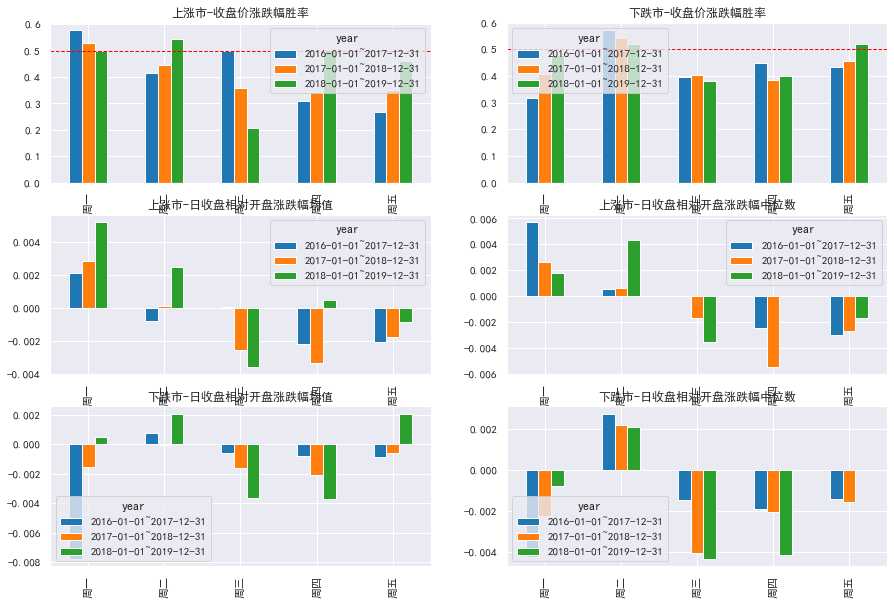

In [25]:
dfs_up=[]
dfs_down=[]
for i in range(2016,2019):
    start='{}-01-01'.format(i)
    end='{}-12-31'.format(i+1)
    data=get_data(CODE,start,end)
    df_up=get_desc(data[data['prev_up']==True]).T
    df_up['year']='{}~{}'.format(start,end)
    df_down=get_desc(data[data['prev_down']==True]).T
    df_down['year']='{}~{}'.format(start,end)
    dfs_up.append(df_up)
    dfs_down.append(df_down)
    
dfs_up=pd.concat(dfs_up)
dfs_down=pd.concat(dfs_down)

f = plt.figure(figsize=(15,10))
ax1 = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)

# 日收盘相对开盘涨跌幅均值','日收盘相对开盘涨跌幅中位数

dfs_up.loc['收盘价涨跌幅胜率'].set_index("year").T.plot(kind='bar',ax=ax1)
ax1.axhline(y=0.5,linewidth=1,ls='--', color='r')
ax1.set_title("上涨市-收盘价涨跌幅胜率")
dfs_down.loc['收盘价涨跌幅胜率'].set_index("year").T.plot(kind='bar',ax=ax2)
ax2.axhline(y=0.5,linewidth=1,ls='--', color='r')
ax2.set_title("下跌市-收盘价涨跌幅胜率")
dfs_up.loc['日收盘相对开盘涨跌幅均值'].set_index("year").T.plot(kind='bar',ax=ax3)
ax3.set_title("上涨市-日收盘相对开盘涨跌幅均值")
dfs_up.loc['日收盘相对开盘涨跌幅中位数'].set_index("year").T.plot(kind='bar',ax=ax4)
ax4.set_title("上涨市-日收盘相对开盘涨跌幅中位数")
dfs_down.loc['日收盘相对开盘涨跌幅均值'].set_index("year").T.plot(kind='bar',ax=ax5)
ax5.set_title("下跌市-日收盘相对开盘涨跌幅均值")
dfs_down.loc['日收盘相对开盘涨跌幅中位数'].set_index("year").T.plot(kind='bar',ax=ax6)
ax6.set_title("下跌市-日收盘相对开盘涨跌幅中位数")

从上图看来不同时间段周内效应会有一定的变化，其中周三的胜率逐步下降非常明显。

---

# 循环回测

分别简单根据上图测试了自2015年至2020年的每年数据。发现一个有趣的现象，虽然正向收益的年份，收益率均不如基准，但是在负向收益的年份，却可以产生较少的负向收益，甚至产生正向收益（这应该是因为我们区分了上涨市和下跌市的不同操作而做到的），并且所有年份中的策略最大回撤均低于基准最大回撤。

所以这中策略应该还算是一个可以备选的策略。

---

以`399300`作为基准比较

In [26]:

def buy_2018(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1, 2):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (1,):
            return row['open']
        else:
            return row['close']
        
def sell_2018(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1, 2,):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (1,):
            return row['close']
        else:
            return row['open']


def buy_2019(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (1,):
            return row['open']
        else:
            return row['close']


def sell_2019(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday']==(1,):
            return row['close']
        else:
            return row['open']


def buy_2020(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1):
            return row['open']
        else:
            return row['close']
    if row['prev_down'] == True:
        if row['weekday'] in (1, 4):
            return row['open']
        else:
            return row['close']


def sell_2020(index, row, data):
    if row['prev_up'] == True:
        if row['weekday'] in (0, 1):
            return row['close']
        else:
            return row['open']
    if row['prev_down'] == True:
        if row['weekday'] in (1, 4):
            return row['close']
        else:
            return row['open']


x = get_data(CODE, '2001-12-01', '2021-12-31')
y = get_data('399300', '2001-12-01', '2021-12-31')

x18 = x['2018-01-01':'2018-12-31'].copy()
y18 = y['2018-01-01':'2018-12-31'].copy()
x18.loc[(x18['prev_up'] == True) & (x18['nextday'].isin([0, 2])), 'buy'] = 1
x18.loc[(x18['prev_down'] == True) & (x18['nextday'].isin([1])), 'buy'] = 1
x18.loc[(x18['prev_up'] == True) & (~x18['nextday'].isin([0, 2])), 'sell'] = 1
x18.loc[(x18['prev_down'] == True) & (~x18['nextday'].isin([1])), 'sell'] = 1

x19 = x['2019-01-01':'2019-12-31'].copy()
y19 = y['2019-01-01':'2019-12-31'].copy()
x19.loc[(x19['prev_up'] == True) & (x19['nextday'].isin([0])), 'buy'] = 1
x19.loc[(x19['prev_down'] == True) & (x19['nextday'].isin([1])), 'buy'] = 1
x19.loc[(x19['prev_up'] == True) & (~x19['nextday'].isin([0])), 'sell'] = 1
x19.loc[(x19['prev_down'] == True) & (~x19['nextday'].isin([1])), 'sell'] = 1

x20 = x['2020-01-01':'2020-12-31'].copy()
y20 = y['2020-01-01':'2020-12-31'].copy()
x20.loc[(x20['prev_up'] == True) & (x20['nextday'].isin([0, 1,3])), 'buy'] = 1
x20.loc[(x20['prev_down'] == True) & (x20['nextday'].isin([0,1, 4])), 'buy'] = 1
x20.loc[(x20['prev_up'] == True) & (~x20['nextday'].isin([0, 1,3])), 'sell'] = 1
x20.loc[(x20['prev_down'] == True) & (~x20['nextday'].isin([0,1, 4])), 'sell'] = 1

d={}
d['2018-01-01~2018-12-31']=backtest(x18,
             benchmark_pd=y18,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2018,
             sell_price_func=sell_2018)
d['2019-01-01~2019-12-31']=backtest(x19,
             benchmark_pd=y19,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2019,
             sell_price_func=sell_2019)
d['2020-01-01~2020-12-31']=backtest(x20,
             benchmark_pd=y20,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2020,
             sell_price_func=sell_2020)

every_year_stats = pd.DataFrame({k:v.stats() for k,v in d.items()}).T
every_year_reports = pd.DataFrame({k:v.report() for k,v in d.items()}).T

243it [00:00, 975.53it/s]
244it [00:00, 1225.68it/s]
243it [00:00, 752.34it/s]


In [27]:
every_year_stats.sort_index()[['基准收益','策略收益']]

,基准收益,策略收益
2018-01-01~2018-12-31,-0.2615,-0.1120
2019-01-01~2019-12-31,0.3881,0.2032
2020-01-01~2020-12-31,0.2459,0.9969


In [28]:
print(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)']].cumsum().join(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)','盈利次数','亏损次数','未结束交易购买金额','未结束交易当前价值']],lsuffix='cumsum').join(every_year_stats.sort_index()[['基准最大回撤','策略最大回撤']]).to_markdown())

|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2018-01-01~2018-12-31 |                                        0.744251 |                            0.890506 |                                  0.744251 |                      0.890506 |         27 |         31 |                  0   |                  0   |      -0.316742 |     -0.141443  |
| 2019-01-01~2019-12-31 |                                        2.10205  |                            2.0958   |                                  1.3578   |                      1.20529  |         17 |        

In [29]:
print(every_year_stats.sort_index()[['基准收益','策略收益']].cumsum().join(every_year_stats.sort_index()[['基准收益','策略收益','基准最大回撤','策略最大回撤']],lsuffix='cumsum').to_markdown())

|                       |   基准收益cumsum |   策略收益cumsum |   基准收益 |   策略收益 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|-----------------:|-----------------:|-----------:|-----------:|---------------:|---------------:|
| 2018-01-01~2018-12-31 |        -0.261531 |       -0.11196   |  -0.261531 |  -0.11196  |      -0.316742 |     -0.141443  |
| 2019-01-01~2019-12-31 |         0.126577 |        0.0912565 |   0.388109 |   0.203216 |      -0.131147 |     -0.0851096 |
| 2020-01-01~2020-12-31 |         0.372517 |        1.08814   |   0.245939 |   0.996883 |      -0.162244 |     -0.127241  |


---

与`159949`比较

---

In [30]:
d={}
d['2018-01-01~2018-12-31']=backtest(x18,
             benchmark_pd=x18,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2018,
             sell_price_func=sell_2018)
d['2019-01-01~2019-12-31']=backtest(x19,
             benchmark_pd=x19,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2019,
             sell_price_func=sell_2019)
d['2020-01-01~2020-12-31']=backtest(x20,
             benchmark_pd=x20,
             buy_comm=0,
             sell_comm=0,
             buy_limit_comm=0,
             sell_limit_comm=0,
             buy_price_func=buy_2020,
             sell_price_func=sell_2020)

every_year_stats = pd.DataFrame({k:v.stats() for k,v in d.items()}).T
every_year_reports = pd.DataFrame({k:v.report() for k,v in d.items()}).T

print(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)']].cumsum().join(every_year_reports.sort_index()[['基准浮动盈亏(基准最后收盘/基准最先开盘)','浮动盈亏(结算价值/初始资金)','盈利次数','亏损次数','未结束交易购买金额','未结束交易当前价值']],lsuffix='cumsum').join(every_year_stats.sort_index()[['基准最大回撤','策略最大回撤']]).to_markdown())

243it [00:00, 964.28it/s]
244it [00:00, 1251.70it/s]
243it [00:00, 749.81it/s]


|                       |   基准浮动盈亏(基准最后收盘/基准最先开盘)cumsum |   浮动盈亏(结算价值/初始资金)cumsum |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   浮动盈亏(结算价值/初始资金) |   盈利次数 |   亏损次数 |   未结束交易购买金额 |   未结束交易当前价值 |   基准最大回撤 |   策略最大回撤 |
|:----------------------|------------------------------------------------:|------------------------------------:|------------------------------------------:|------------------------------:|-----------:|-----------:|---------------------:|---------------------:|---------------:|---------------:|
| 2018-01-01~2018-12-31 |                                        0.646884 |                            0.890506 |                                  0.646884 |                      0.890506 |         27 |         31 |                  0   |                  0   |      -0.416072 |     -0.141443  |
| 2019-01-01~2019-12-31 |                                        2.15947  |                            2.0958   |                                  1.51259  |                      1.20529  |         17 |        